# Example Fe55 notebook for creating noise distributions

Initially written for the bootcamp at SLAC Nov 2018 by Simon Krughoff

### Setup

Before running this notebook, you'll need to set up the `obs_lsst` package. Before doing the setup procedure below, you might want to run the notebook until it crashes so you see what the error message looks like.

Step-by-step instructions:

1. Start a terminal in JupyterLab. In the terminal, setup the Stack with the command `source /opt/lsst/software/stack/loadLSST.bash` and then issue the command `setup lsst_distrib` to allow you to run scons in a subsequent step.

2. Create and/or switch into a folder where you want to put your local versions of the LSST Stack (e.g., `~/repos`)

Run the following commands

```
git clone https://github.com/lsst/obs_lsstCam.git
cd obs_lsstCam
setup -j -r .
scons
```

3. Add `setup -k -r path_to_repos/obs_lsstCam` to `$HOME/notebooks/.user_setups`.

4. Restart your kernel.

Just for fun, check what version of the Stack you are using. This notebook has been tested on `w_2018_45`.

In [1]:
! eups list -s | grep lsst_distrib

lsst_distrib          16.0-1-g3bbe181+31 	current w_2018_45 setup


### Imports

In [2]:
%matplotlib inline

# system imports
from matplotlib import pylab as plt
from scipy.optimize import leastsq
import numpy as np
import os

# LSST stack imports
from lsst.daf.persistence import Butler
import lsst.afw.display as afwDisplay
from lsst.ip.isr import IsrTask
import lsst.afw.detection as afwDetection
import lsst.afw.math as afwMath


# Firefly client imports
from firefly_client import FireflyClient
from IPython.display import IFrame

### Set up the config for the ISR task.  This essentially turns off all processing other than overscan and bias correction.

In [3]:
isr_config = IsrTask.ConfigClass()

isr_config.doDark=False
isr_config.doFlat=False
isr_config.doFringe=False
isr_config.doDefect=False
isr_config.doAddDistortionModel=False
isr_config.doLinearize=False

### Construct the `IsrTask` with the above configuration

In [4]:
isr = IsrTask(config=isr_config)

### Retrieve the data necessary to perform ISR.  This is just the raw data and the bias frame.  Note there are multiple integrations.  This notebook only looks at one of them.

In [5]:
BOOTCAMP_REPO_DIR= '/project/bootcamp/repo_RTM-007/'
butler = Butler(BOOTCAMP_REPO_DIR)
print(butler.queryMetadata('raw', ['visit'], dataId={'imageType': 'FE55', 'testType': 'FE55'}))

dId = {'visit': 258334666, 'detector': 2}
raw = butler.get('raw', **dId)
bias = butler.get('bias', **dId)

[258334666, 258334978, 258335291, 258335602, 258335913]


In [6]:
result = isr.run(raw, bias=bias)

### Set up the necessary classes for using firefly to look at the data.

In [7]:
my_channel = '{}_test_channel'.format(os.environ['USER'])
server = 'https://lsst-lspdev.ncsa.illinois.edu'


ff='{}/firefly/slate.html?__wsch={}'.format(server, my_channel)
IFrame(ff,800,600)

In [8]:
afwDisplay.setDefaultBackend('firefly')
afw_display = afwDisplay.getDisplay(frame=1, 
                                    name=my_channel)

### Display the frame after ISR

In [9]:
afw_display.mtv(result.exposure)

### Plot and calculate the noise in each image amp

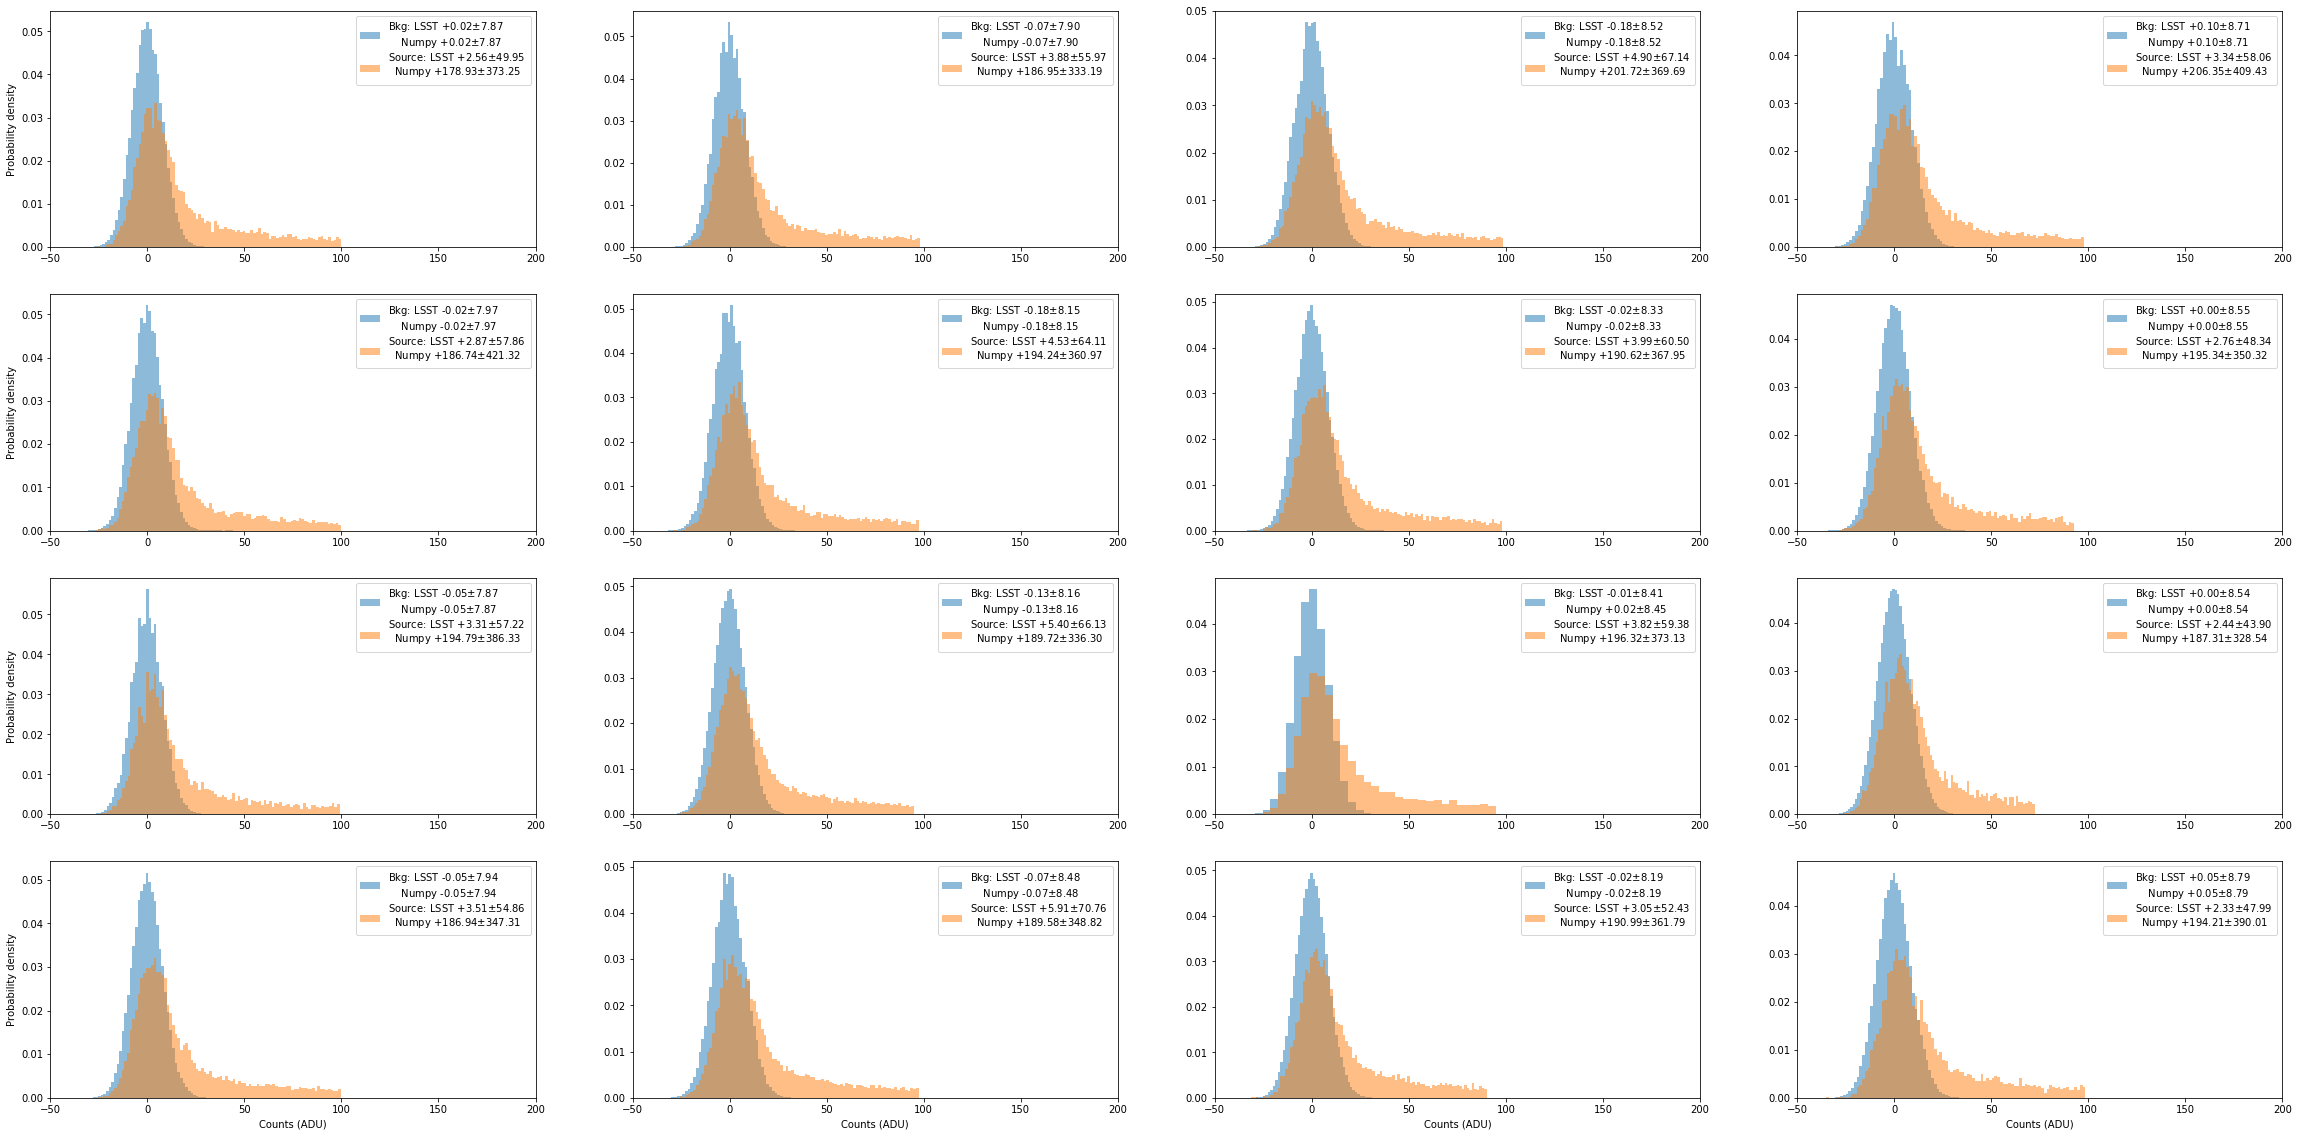

In [62]:
xs = []
ys = []
fits = []
fig, axs = plt.subplots(4, 4, figsize=(40, 20))
detector = result.exposure.getDetector()
masked_img = result.exposure.getMaskedImage()
for i,amp in enumerate(detector):
    work_img = masked_img[amp.getBBox()]
    arr = work_img.getImage().getArray()
    
    bkgd = np.median(arr) # estimate a background and subtract it
    arr -= bkgd # this is pointers so running once means we have changed the array

    # detect sources and set mask bit
    thresh = afwDetection.Threshold(100)
    fs = afwDetection.FootprintSet(work_img, thresh) # detect hits
    fs = afwDetection.FootprintSet(fs, 1, False) # grow the detection footprints
    fs.setMask(work_img.mask, "DETECTED")
    fs.makeHeavy(work_img) # List of pixels plus values

    foots = fs.getFootprints()

    maskDict = work_img.getMask().getMaskPlaneDict()
    detected = maskDict["DETECTED"]

    mask_pixels = work_img.getMask().getArray()
    pixels =  work_img.getImage().getArray()
    
    # calculate statistics on images with and without detected mask using StatisticsControl
    sctrl = afwMath.StatisticsControl()
    sctrl.setAndMask(detected)
    stat = afwMath.makeStatistics(work_img, afwMath.STDEV | afwMath.MEAN , sctrl)
    lsstMeanDetected = stat.getValue(afwMath.MEAN)
    lsstStdDetected = stat.getValue(afwMath.STDEV)

    sctrl.setAndMask(~detected)
    stat = afwMath.makeStatistics(work_img, afwMath.STDEV | afwMath.MEAN , sctrl)
    lsstMean = stat.getValue(afwMath.MEAN)
    lsstStd = stat.getValue(afwMath.STDEV)


    # calculate statistics on images with and without detected mask using pixel values
    meanDetected = pixels[np.bitwise_and(mask_pixels,2**detected) == 2**detected].mean()
    stdDetected = pixels[np.bitwise_and(mask_pixels,2**detected) == 2**detected].std()

    mean = pixels[np.bitwise_and(mask_pixels,2**detected) != 2**detected].mean()
    std = pixels[np.bitwise_and(mask_pixels,2**detected) != 2**detected].std()

    
    indx = i%4
    indy = i//4
    bins = axs[indx][indy].hist(pixels[np.bitwise_and(mask_pixels,2**detected) != 2**detected], bins=100, density=True, alpha=0.5,
                                label='Bkg: LSST {:+.2f}$\pm${:.2f} \n    Numpy {:+.2f}$\pm${:.2f}'.format(lsstMean, lsstStd, mean, std))
    axs[indx][indy].hist(pixels[np.bitwise_and(mask_pixels,2**detected) == 2**detected], bins=bins[1], density=True,  alpha=0.5,
                         label='Source: LSST {:+.2f}$\pm${:.2f} \n  Numpy {:+.2f}$\pm${:.2f}'.format(lsstMeanDetected, lsstStdDetected, 
                                                                                                     meanDetected, stdDetected))
    axs[indx][indy].legend()
    axs[indx][indy].set_xlim(-50,200)
    if indx == 3:
        axs[indx][indy].set_xlabel('Counts (ADU)')
    if indy == 0:
        axs[indx][indy].set_ylabel('Probability density')

